# AI Clinique #14 : Discover patterns in your data with Clustering
## Clustering presentation

- __Date__: 26-11-2021
- __Presentator__: Nicolas Clavel
- __Datasets__: For this hands-on, we will be using the following open source datasets
    - Iris dataset (included in sklearn.datasets)
    - Moon distribution samples (included in sklearn.datasets)
- __Packages__: requirements.txt
- __Documentation__:
    - sklearn clustering documentation: https://scikit-learn.org/stable/modules/clustering.html
    - KMeans interactive demo : https://github.com/SAMY-ER/Interactive-Kmeans


### Table of contents
- __1. KMeans clustering__
- __2. Hierarchical clustering__
- __3. DBSCAN clustering__
- __4. t-SNE 2D representation__

#### Imports

In [33]:
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import datasets
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from matplotlib import pyplot
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from tools import *

## 1. KMeans clustering

#### Load the dataset
A quick description of the dataset can be found here : https://archive.ics.uci.edu/ml/datasets/Iris

In [44]:
iris = datasets.load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

# Get targets & targets labels
target_labels = {value:label for value, label in enumerate(iris.target_names)}
iris_df['Species'] = iris.target
iris_df['Species'] = iris_df['Species'].map(target_labels)

iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


#### Description

In [45]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Features consist of :
- sepal length (cm)
- sepal width (cm)
- petal length (cm)
- petal width (cm)

The target is the Species (setosa, versicolor & verginica), but we will drop it as we focus on clustering (unsupervised learning)

#### Datavizualisation

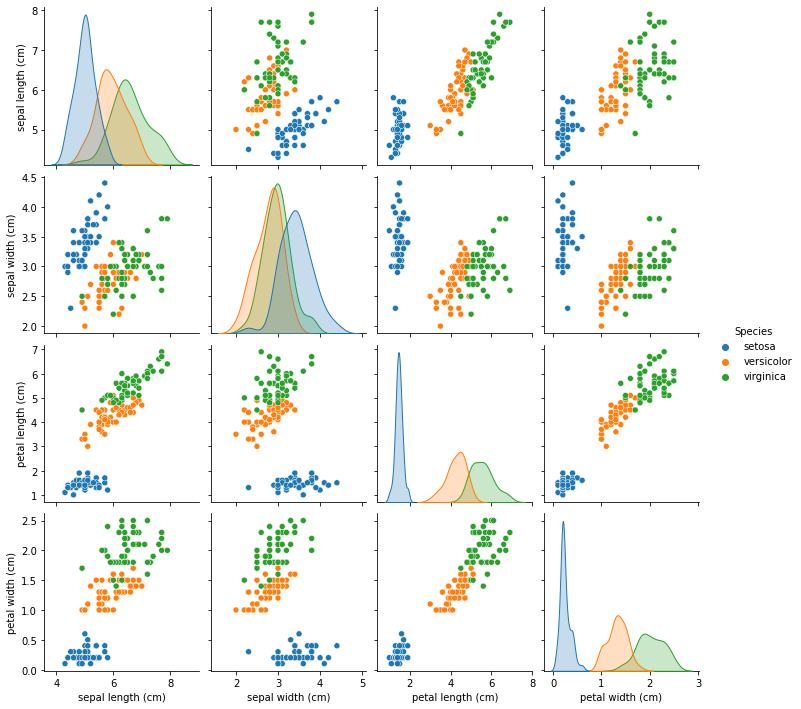

In [52]:
sns.pairplot(iris_df, hue='Species')

<AxesSubplot:xlabel='Species', ylabel='sepal length (cm)'>

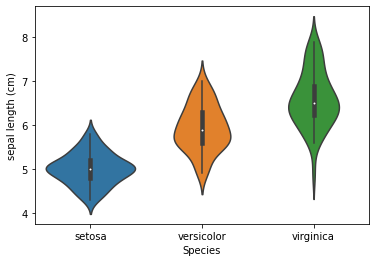

In [47]:
sns.violinplot(x='Species', y='sepal length (cm)', data=iris_df, size=6)

<AxesSubplot:xlabel='Species', ylabel='petal length (cm)'>

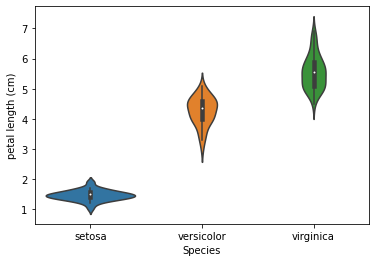

In [48]:
sns.violinplot(x='Species', y='petal length (cm)', data=iris_df, size=6)

For each species, the distribution of data seems to be distributed around a value.

#### Objective :

Let's assume that the __species are not known__   
The goal is to __learn something from the data by exploring it__, without any knowledge of the target, to discover if observations have similar properties.  
To do this, we use clustering methods (unsupervised), and its most famous one : __KMeans Clustering__ to identify similar groups.  
First, we must remove the targets, as we are making no assumptions regarding the species.

In [49]:
iris_species = iris_df['Species']
iris_df = iris_df.drop('Species', axis=1)

#### First KMeans clustering
In the KMeans clustering, __we must assume the number of clusters__.

In [50]:
# Train kmeans
nb_clusters = 3
kmeans = KMeans(n_clusters=nb_clusters, n_init=50, max_iter=1000)
kmeans.fit(iris_df)

# Get cluster labels
labels = [f'cluster {l+1}' for l in kmeans.labels_]
iris_df['Cluster'] = labels

# Get true lables (species)
iris_df['Species'] = iris_species

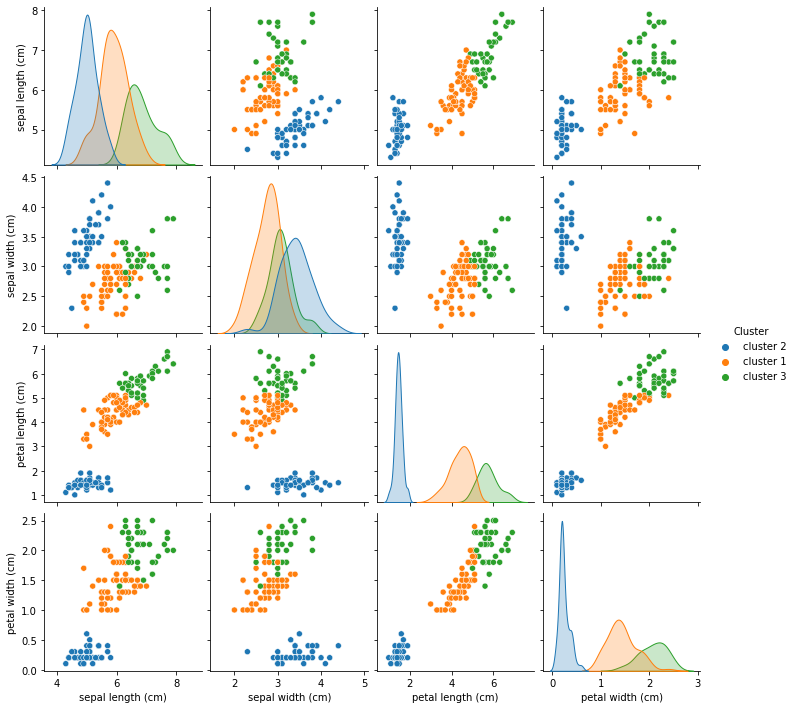

In [51]:
sns.pairplot(iris_df , hue='Cluster')

In [53]:
pd.crosstab(iris_df['Cluster'], iris_df['Species'])

Species,setosa,versicolor,virginica
Cluster,,,
cluster 1,0,48,14
cluster 2,50,0,0
cluster 3,0,2,36


The clustering gathered the iris in groups that seem to __nearly correspond to the species__  
However, we made the assumption of the number of groups (3), as we already know the number of species. It can also be found from vizual analysis of the distributions.  
But __how to determine this number of clusters ?__

#### How to find the number of clusters ?

In [54]:
kmax = 12

##### The Elbow method
Calculate the __Within-Cluster-Sum of Squared Errors (WSS)__ for different values of k, and choose the k for which WSS is suddently less decreasing. In the plot of WSS-versus-k, this is visible as an __elbow__.

In [55]:
iris_df = iris_df.drop(['Species', 'Cluster'], axis=1)

In [56]:
iris_matrix = iris_df.values
k_list = []
sum_squared_distance = []
inertia = []
for k in range(1, kmax+1):
    k_list.append(k)
    kmeans = KMeans(n_clusters = k).fit(iris_matrix)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(iris_matrix)
    sum_squared_distance.append(kmeans.inertia_)

ssd_df = pd.DataFrame({'nb_cluster': k_list, 'sum_squared_distances': sum_squared_distance})

<AxesSubplot:xlabel='nb_cluster', ylabel='sum_squared_distances'>

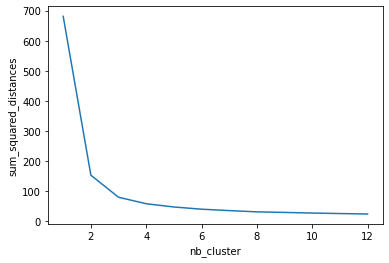

In [57]:
sns.lineplot(x="nb_cluster", y="sum_squared_distances", data=ssd_df)

#### Interactive KMeans training
Demo with https://github.com/SAMY-ER/Interactive-Kmeans

#### KMeans limits
Let's try on very different distributions : moon's distribution

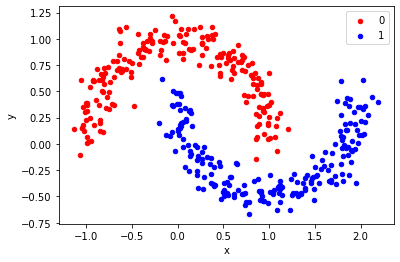

In [58]:
# 2d samples with moon's shape
X, y = datasets.make_moons(n_samples=400, noise=0.1)
df_moon_samples = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
plot_moon_samples(df_moon_samples)

In [59]:
# KMeans clustering
nb_clusters = 2
kmeans = KMeans(n_clusters=nb_clusters, n_init=50, max_iter=10000)
kmeans.fit(df_moon_samples[['x', 'y']])

# Get cluster labels
df_moon_samples['kmeans_cluster'] = kmeans.labels_

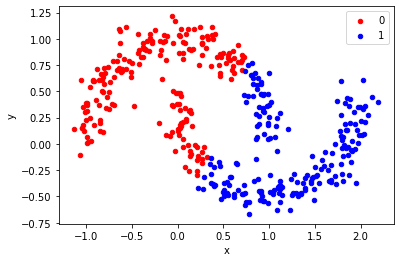

In [60]:
plot_moon_samples(df_moon_samples, color_label='kmeans_cluster', colors={0:'red', 1:'blue'})

#### Conclusion:
KMeans is not appropriate when the data distribution is not normal or a mix of gaussians, but it is a first easy approach  
Let's try another algorithm.

## 2. Hierarchical clustering
The __AgglomerativeClustering__ object performs a __hierarchical clustering__ using a __bottom up__ approach: each observation starts in its own cluster, and __clusters are successively merged together__. The linkage criteria determines the metric used for the merge strategy:
- __ward__ linkage minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
- __average__ linkage minimizes the average of the distances between all observations of pairs of clusters.
- __complete__ or __maximum__ linkage minimizes the maximum distance between observations of pairs of clusters.
- __single__ minimizes the distance between the closest observations of pairs of clusters.

In [61]:
agglo = AgglomerativeClustering(linkage='average', compute_distances=True)
agglo.fit(df_moon_samples[['x', 'y']])
df_moon_samples['agglomerative_cluster'] = agglo.labels_

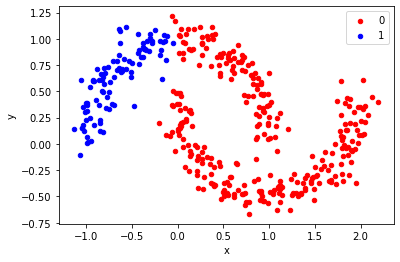

In [62]:
plot_moon_samples(df_moon_samples, color_label='agglomerative_cluster', colors={0:'red', 1:'blue'})

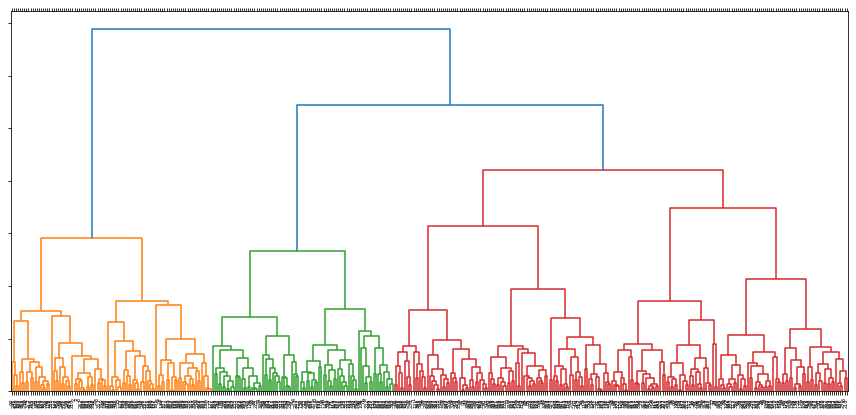

In [63]:
## dendogram
plot_dendrogram(agglo)

#### Conclusion:
Hierarchical Clustering is not very effective on this samples distribution.
Let's try another method

## 3. DBSCAN Clustering
The __DBSCAN__ algorithm views __clusters as areas of high density separated by areas of low density__. Due to this rather generic view, __clusters found by DBSCAN can be any shape__, as opposed to k-means which assumes that clusters are convex shaped.  
The two parameters are __eps__ which is the radius of the circle scanner, and __min_samples__ which is the minimum number of samples that must be in the scanner to define a point as a __core__ point.
- __Core__ points have > __min_samples_ points in their radius
- __Border__ points does not have > __min_samples_points in their radius, but they are reachable by at least 1 core point
- __Edge__ or __Noise__ points have no points in their radius
Higher __min_samples__ or lower __eps__ indicate higher density necessary to form a cluster (these are the two DBSCAN parameters).

In [65]:
eps = 0.2 # radius 0.4 around a point
min_samples = 8 # points minimum in the circle of radius 0.4

In [66]:
db = DBSCAN(eps=eps, min_samples=min_samples)
db.fit(df_moon_samples[['x', 'y']])
df_moon_samples['dbscan_cluster'] = db.labels_

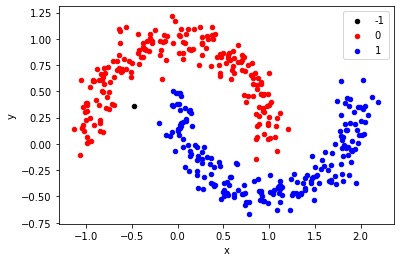

In [67]:
color_map = {-1:'black', 0:'red', 1:'blue', 2: 'orange', 3: 'purple', 4: 'darkblue', 5: 'darkgreen', 6: 'darkred'}
plot_moon_samples(df_moon_samples, color_label='dbscan_cluster', colors=color_map)

#### Interactive DBSCAN training
https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/

#### Conclusion:
DBSCAN clustering works well on various shapes, but these parameters are hard to set.

## 4. t-SNE 2D representation
t-SNE is computationally intensive, so we will reduce the dimension using PCA before applying it

#### Get mnist dataset
Each digit (0 to 9) is representated in a 8x8 image which is a 64 dimensionality space

In [68]:
# load dataset
mnist = datasets.load_digits()
X = mnist.data / 255.0
y = mnist.target
print('X & y shapes:')
print(X.shape, y.shape)

# transform to dataframe
cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df_mnist = pd.DataFrame(X,columns=cols)
df_mnist['y'] = y
df_mnist['label'] = df_mnist['y'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df_mnist.shape))

# to reproduce our results
np.random.seed(42)
rnd_perm = np.random.permutation(df_mnist.shape[0])

X & y shapes:
(1797, 64) (1797,)
Size of the dataframe: (1797, 66)


#### Vizualisation

<Figure size 432x288 with 0 Axes>

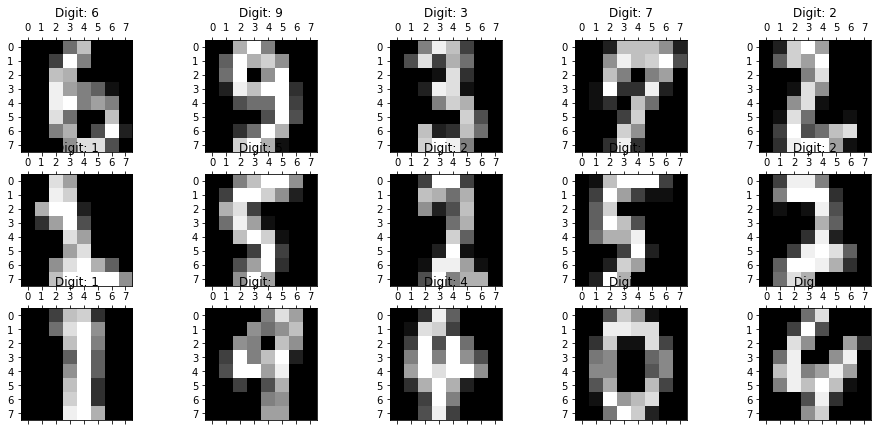

In [69]:
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(df_mnist.loc[rnd_perm[i],'label'])) )
    ax.matshow(df_mnist.loc[rnd_perm[i], cols].values.reshape((8,8)).astype(float))
plt.show()

#### Reduce the dimension with PCA (Principal Component Analysis)

In [70]:
# PCA : keep 3 first dimensions
n_obs = 10000
n_components = 4
df_mnist_sub = df_mnist.loc[rnd_perm[:n_obs],:].copy()
data_mnist_subset = df_mnist_sub[cols].values

pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(data_mnist_subset)

df_mnist_sub['pca_1'] = pca_result[:,0]
df_mnist_sub['pca_2'] = pca_result[:,1] 
df_mnist_sub['pca_3'] = pca_result[:,2]
df_mnist_sub['pca_4'] = pca_result[:,3]

#### t-SNE

In [71]:
dimension=2
tsne = TSNE(n_components=dimension, verbose=1)
tsne_results = tsne.fit_transform(data_mnist_subset)

c:\users\nicolas.clavel\documents\projets\engie\clustering\clustering_venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\nicolas.clavel\documents\projets\engie\clustering\clustering_venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1797 samples in 0.000s...
[t-SNE] Computed neighbors for 1797 samples in 0.131s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1797
[t-SNE] Computed conditional probabilities for sample 1797 / 1797
[t-SNE] Mean sigma: 0.045434
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.540379
[t-SNE] KL divergence after 1000 iterations: 0.742261


#### PCA vizualisation

<AxesSubplot:xlabel='pca_1', ylabel='pca_2'>

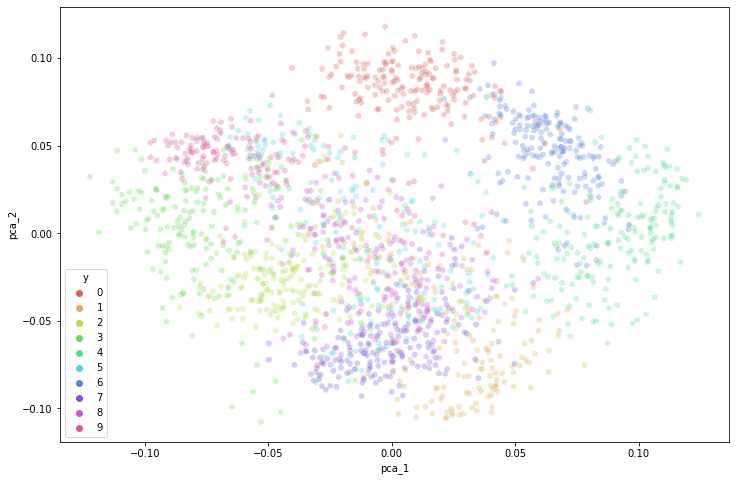

In [72]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    x='pca_1', y='pca_2',
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_mnist_sub,
    legend="full",
    alpha=0.3
)

#### t-SNE vizualisation

<AxesSubplot:xlabel='tsne_2D_1', ylabel='tsne_2D_2'>

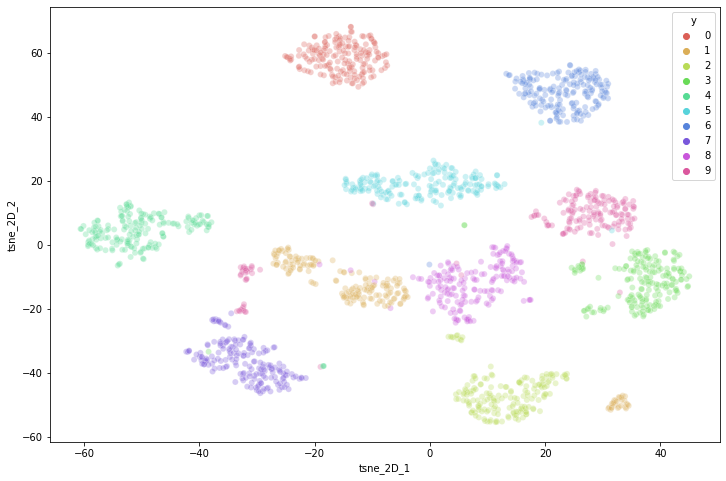

In [73]:
df_mnist_sub['tsne_2D_1'] = tsne_results[:,0]
df_mnist_sub['tsne_2D_2'] = tsne_results[:,1]

plt.figure(figsize=(12,8))
sns.scatterplot(
    x='tsne_2D_1', y='tsne_2D_2',
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_mnist_sub,
    legend="full",
    alpha=0.3
)

#### Let's try KMeans on mnist

In [74]:
nb_clusters_mnist = 10
pixel_cols = [col for col in df_mnist.columns if 'pixel' in col]
kmeans_mnist = KMeans(n_clusters=nb_clusters_mnist, n_init=50, max_iter=10000)

kmeans_mnist.fit(df_mnist[pixel_cols])

# Get cluster labels
df_mnist['kmeans_cluster'] = kmeans_mnist.labels_

In [75]:
pd.crosstab(df_mnist['label'], df_mnist['kmeans_cluster'])

kmeans_cluster,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,0,0,0,0,0,0,1,177,0,0
1,0,99,2,0,55,24,0,0,1,1
2,2,8,0,3,2,148,0,1,0,13
3,13,7,0,7,0,0,0,0,2,154
4,0,4,0,8,5,0,164,0,0,0
5,42,0,1,0,0,0,2,0,136,1
6,0,2,177,0,1,0,0,1,0,0
7,0,2,0,177,0,0,0,0,0,0
8,51,102,2,5,5,3,0,0,4,2


#### Conclusion:
- __t-SNE__ is useful to __find the number of clusters__ and have a 2D view of the osvervations.  
- Be careful, t-SNE is __computationally intensive__, one must use __PCA__ before to reduce the dimension